# Load libraries 

In [5]:
#load libraries 
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

import root_pandas
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from scipy.optimize import curve_fit


Welcome to JupyROOT 6.23/01


# Load tuple files
The following will automatically download the files from https://userweb.jlab.org/~spaul/sidis_tuple_examples, if they are not already downloaded.  

In [6]:
import urllib.request, os

for filename in "example_mc.root", "example_data.root":
    if not (filename in os.listdir(".")):
        url = 'https://userweb.jlab.org/~spaul/sidis_tuples_examples/' +filename
        urllib.request.urlretrieve(url, filename)
        print("downloaded file from " + url)
    else:
        print("found file: " + filename + ",\t no need to re-download")
print("done downloading files")

found file: example_mc.root,	 no need to re-download
found file: example_data.root,	 no need to re-download
done downloading files


Now load the tuples from the files.

In [7]:
#electrons: events with at least one electron which passes DIS event selection cuts
#hadrons: events with at least one electron (passing cuts above) and at least one charged hadron
#dihadrons: events with at least one electron and two charged hadrons, one of which is a "leading" pion, (ie, z>0.5)

data_electrons = root_pandas.read_root("example_data.root", "electrons")
data_hadrons = root_pandas.read_root("example_data.root", "hadrons")
data_dihadrons = root_pandas.read_root("example_data.root", "dihadrons")

#same for Monte-Carlo simulations
mc_electrons = root_pandas.read_root("example_mc.root", "electrons")
mc_hadrons = root_pandas.read_root("example_mc.root", "hadrons")
mc_dihadrons = root_pandas.read_root("example_mc.root", "dihadrons")

In [8]:
#print the number of entries in each tuple
print("data electrons\tlength =", len(data_electrons))
print("data hadrons\tlength =", len(data_hadrons))
print("data dihadrons\tlength =", len(data_dihadrons))
print("")
print("mc electrons\tlength =", len(mc_electrons))
print("mc hadrons\tlength =", len(mc_hadrons))
print("mc dihadrons\tlength =", len(mc_dihadrons))

data electrons	length = 502742
data hadrons	length = 298031
data dihadrons	length = 5877

mc electrons	length = 218458
mc hadrons	length = 322570
mc dihadrons	length = 981


In [9]:
#print the list of variables in each tuple (these are the same for data and monte-carlo)
for df, name in (data_electrons,"electrons"), (data_hadrons,"hadrons"), (data_dihadrons,"dihadrons"):
    print(name + ":")
    print(df.columns)
    print("\n")


electrons:
Index(['E', 'helicity', 'e_p', 'e_th', 'e_ph', 'nelectrons', 'nu', 'Q2', 'x',
       'y', 'W', 'e_DC1x', 'e_DC2x', 'e_DC3x', 'e_DC1y', 'e_DC2y', 'e_DC3y',
       'e_PCALx', 'e_PCALy', 'e_ecalfrac', 'e_pcal', 'e_vz', 'npip', 'npim',
       'npp', 'npm', 'nKp', 'nKm', 'nh', 'z_tot'],
      dtype='object')


hadrons:
Index(['nelectrons', 'E', 'helicity', 'e_p', 'e_th', 'e_ph', 'nu', 'Q2', 'x',
       'y', 'W', 'h_chi2pid', 'h_pid', 'h_p', 'h_th', 'h_ph', 'h_DC1x',
       'h_DC1y', 'h_DC2x', 'h_DC2y', 'h_DC3x', 'h_DC3y', 'dvz', 'z', 'h_cm_p',
       'h_cm_th', 'h_cm_ph', 'h_cm_eta', 'h_cm_pt', 'h_eta', 'dtime',
       'dtime_corr'],
      dtype='object')


dihadrons:
Index(['E', 'helicity', 'e_p', 'e_th', 'e_ph', 'nu', 'Q2', 'x', 'y', 'W',
       'h1_chi2pid', 'h2_chi2pid', 'h1_pid', 'h2_pid', 'h1_p', 'h2_p', 'h1_th',
       'h2_th', 'h1_ph', 'h2_ph', 'h1_z', 'h2_z', 'h1_eta', 'h2_eta',
       'h1_cm_p', 'h2_cm_p', 'h1_cm_th', 'h2_cm_th', 'h1_cm_ph', 'h2_cm_ph',
       'h1_cm_et

In [23]:
def binspace(df, query, min, max, nbins):
    ls = np.linspace(min,max,nbins)
    return [df.query("%s> %s and %s < %s" %(query, mn, query, mx)) for mn,mx in zip(ls[:-1],ls[1:])]

def binomialError(num,denom):
    return num/denom*np.sqrt(1/min(1,num)+1/min(1,denom))

def getmeanstd(df, query):
    a = df.eval(query)
    x0, sigma = np.mean(a), np.std(a)
    nbins = 50
    bins = binspace(df,query, x0-5*sigma, x0+5*sigma, nbins)
    x = np.linspace(x0-5*sigma, x0+5*sigma, nbins-1)
    x += (x[1]-x[0])/2
    y = [len(bin) for bin in bins]
    del bins
    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
    popt,pcov = curve_fit(gaus,x,y,p0=[1,x0,sigma])

    return popt[1],abs(popt[2])

# Plots for the electrons tuple

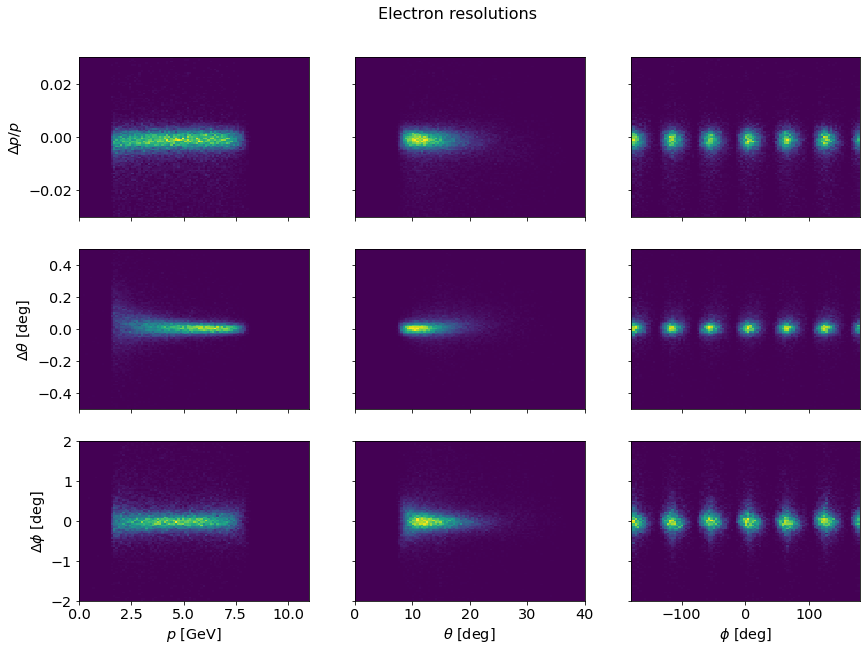

In [11]:
df = mc_electrons.query("e_truth_p != 0 and e_p !=0")

fig,axs = plt.subplots(3,3, figsize=(14,10),sharey='row',sharex='col')
for i,(xvar,xrange) in enumerate(zip(("e_truth_p","e_truth_th*180/3.14159","e_truth_ph*180/3.14159"),
                           ((0,11),(0,40),(-180,180)))):
    axs[0][i].hist2d(df.eval(xvar), (df.e_p-df.e_truth_p)/df.e_p,bins=(100,100), range=(xrange,(-0.03,0.03)))
    axs[1][i].hist2d(df.eval(xvar), (df.e_th-df.e_truth_th)*180/np.pi,bins=(100,100), range=(xrange,(-0.5,0.5)))
    axs[2][i].hist2d(df.eval(xvar), (df.e_ph-df.e_truth_ph)*180/np.pi,bins=(100,100), range=(xrange,(-2,2)))

axs[0][0].set_ylabel("$\\Delta p/p$")
axs[1][0].set_ylabel("$\\Delta\\theta$ [deg]")
axs[2][0].set_ylabel("$\\Delta\\phi$ [deg]")
axs[2][0].set_xlabel("$p$ [GeV]")
axs[2][1].set_xlabel("$\\theta$ [deg]")
axs[2][2].set_xlabel("$\\phi$ [deg]")
fig.suptitle('Electron resolutions', fontsize=16, verticalalignment='top',y=0.95)
plt.show()

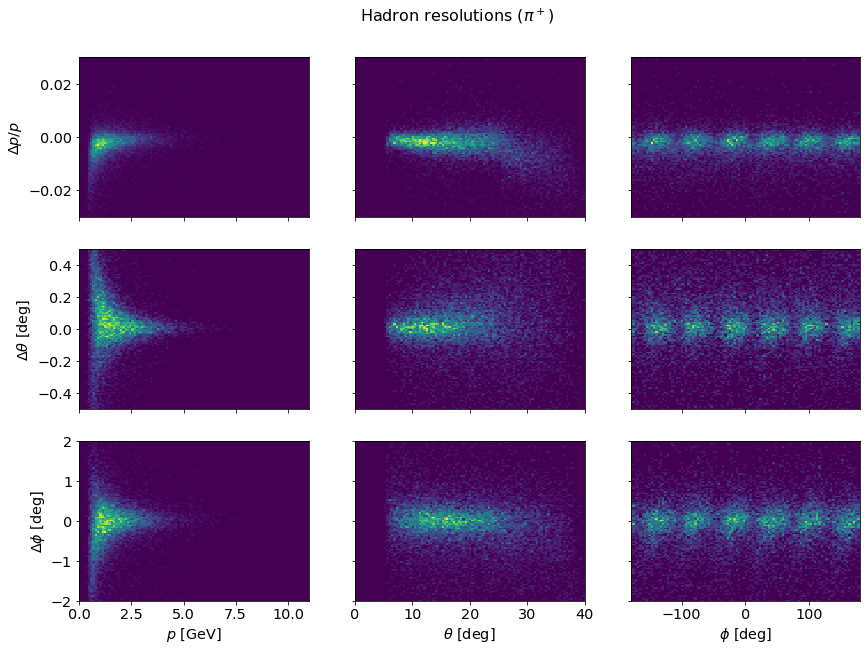

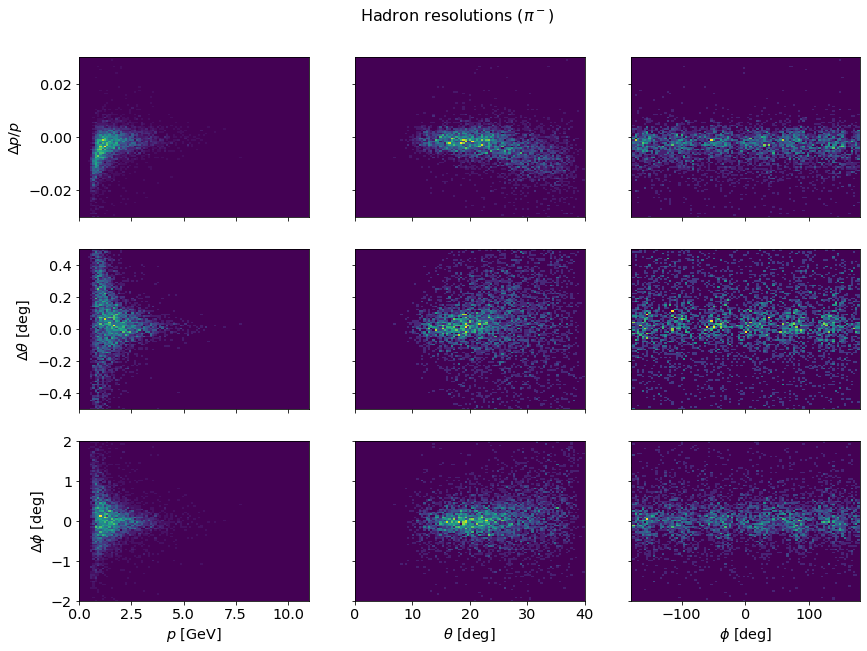

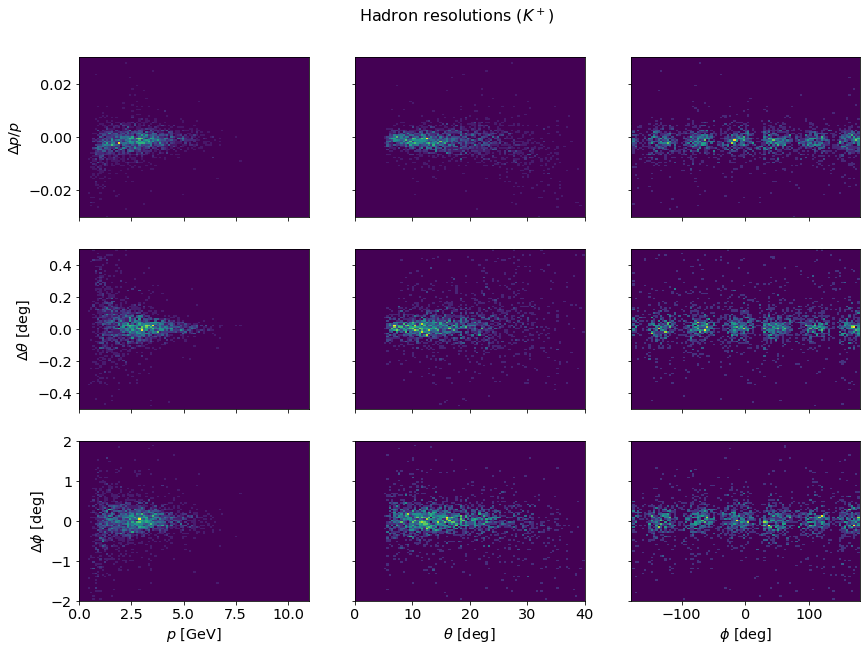

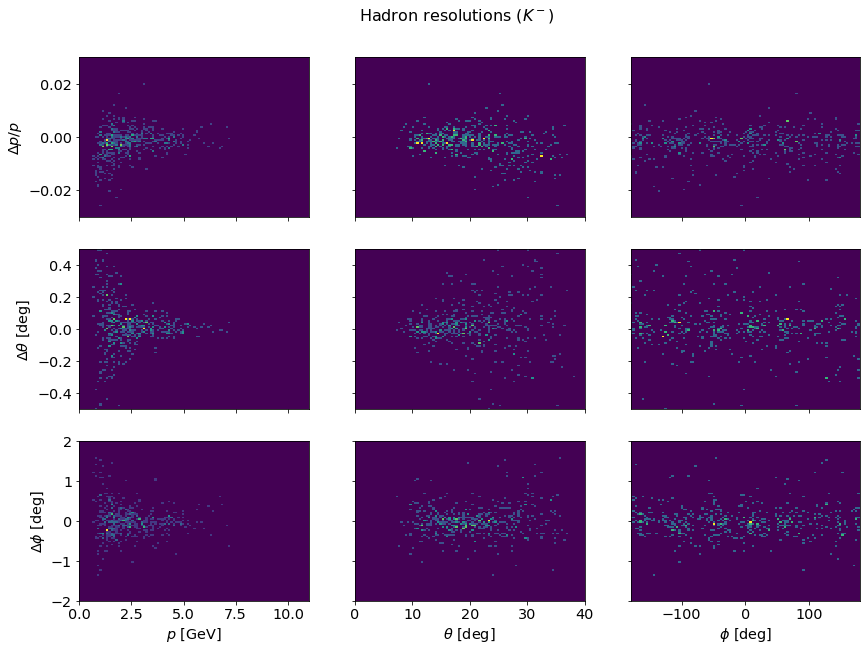

In [12]:
for pid, name in (211, "$\\pi^+$"),(-211, "$\\pi^-$"),(321, "$K^+$"),(-321, "$K^-$"):
    df = mc_hadrons.query("h_truth_p != 0 and h_p !=0 and h_truth_pid == %s"% pid)
    fig,axs = plt.subplots(3,3, figsize=(14,10),sharey='row',sharex='col')
    for i,(xvar,xrange) in enumerate(zip(("h_truth_p","h_truth_th*180/3.14159","h_truth_ph*180/3.14159"),
                               ((0,11),(0,40),(-180,180)))):
        axs[0][i].hist2d(df.eval(xvar), (df.h_p-df.h_truth_p)/df.h_p,bins=(100,100), range=(xrange,(-0.03,0.03)))
        axs[1][i].hist2d(df.eval(xvar), (df.h_th-df.h_truth_th)*180/np.pi,bins=(100,100), range=(xrange,(-0.5,0.5)))
        axs[2][i].hist2d(df.eval(xvar), (df.h_ph-df.h_truth_ph)*180/np.pi,bins=(100,100), range=(xrange,(-2,2)))

    axs[0][0].set_ylabel("$\\Delta p/p$")
    axs[1][0].set_ylabel("$\\Delta\\theta$ [deg]")
    axs[2][0].set_ylabel("$\\Delta\\phi$ [deg]")
    axs[2][0].set_xlabel("$p$ [GeV]")
    axs[2][1].set_xlabel("$\\theta$ [deg]")
    axs[2][2].set_xlabel("$\\phi$ [deg]")
    fig.suptitle('Hadron resolutions (%s)' % name, fontsize=16, verticalalignment='top',y=0.95)
    plt.show()

[-0.09089239942441472, 0.013054082900094357, 0.14087342519575416, 0.14630655268188328, 0.0777282028162057, 0.09625040893029839]
[0.4558679442998484, 0.30047932607906735, 0.32686077887178805, 0.2935094471978428, 0.2597676187719637, 0.18536074377349404]
[0.029617763185474735, -0.009491834078921176, -0.02413635733824247, 0.03366658227071171, 0.1660628442389129, -0.49330903413983906, -0.6577048236990171, -0.8909851777753158]
[0.20013497825321663, 0.2346213053327013, 0.30134818211714415, 0.366346251461434, 0.48148283197148556, 0.5597817612922686, 0.6485697658789741, 0.8942741965160047]
[-0.0868887598668288, -0.049651987141378445, -0.04020926438771699, 0.026562516091560125, -0.061011998044050254, -0.005219558934524564, 0.014195429352132308, -0.06586003008056794, 0.1538693374863773]
[0.3320724210812784, 0.3448709560173506, 0.3237867473398562, 0.35205362945911195, 0.33957774168660476, 0.32053511887271857, 0.3625102117321302, 0.32669545315594317, 0.46690918898292405]


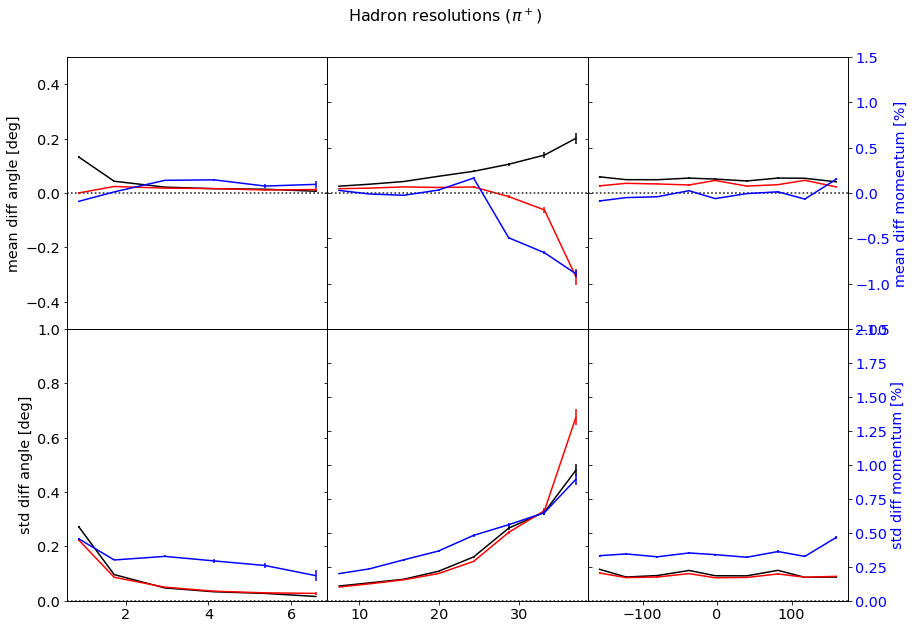

[-0.41465826743963363, -0.018168386501862564, 0.032000230665084874, 0.030039441216146812, -0.012701126400215194]
[0.5918649033809452, 0.3741895583572272, 0.2875513074351392, 0.26874519987721357, 0.25906629013930965]
[-0.0022599127857528744, -0.044553722636837295, 0.00743606166804877, -0.12896452505743963, -0.39915472284127534, -0.5875093090062565, -0.674035975148579]
[0.26124303647062286, 0.278513951231595, 0.33458134973384124, 0.4165410404973185, 0.5264693928469475, 0.5831871851515268, 0.6448168891387723]
[-0.10524349341323545, -0.08195567796945806, -0.130903148172407, -0.04081070487131967, -0.10375639879855486, -0.12005843715687538, -0.03202611019663655, -0.16028237601273512, -0.050135496671090525]
[0.3964661753338907, 0.47922074467812037, 0.4850276210658452, 0.3877528220561038, 0.3956455646840866, 0.45073819826430384, 0.45893009337629503, 0.43960126034406316, 0.4577967618857591]


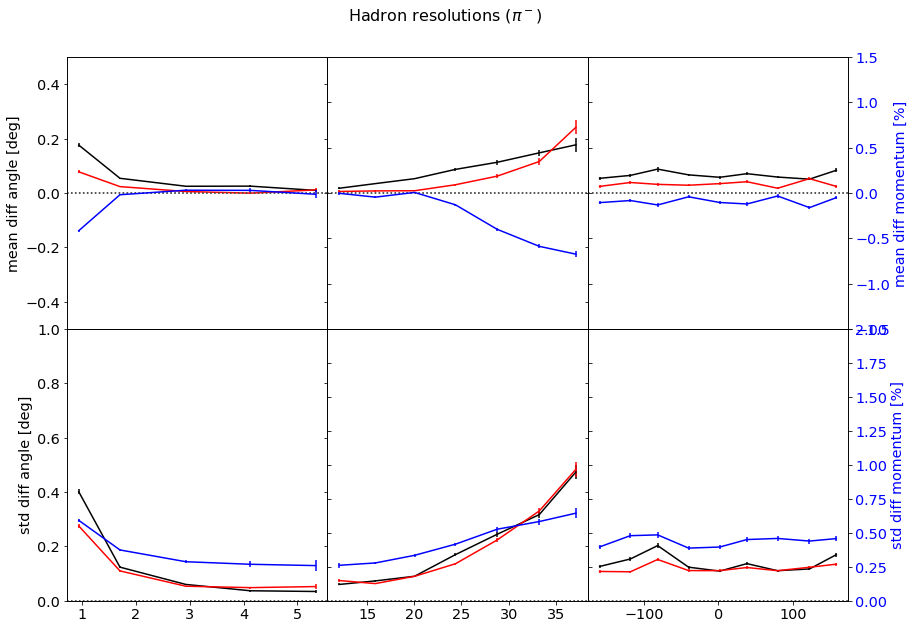

In [25]:
for pid, name in (211, "$\\pi^+$"),(-211, "$\\pi^-$"):#,(321, "$K^+$"),(-321, "$K^-$"):
    df = mc_hadrons.query("h_truth_p != 0 and h_p !=0 and h_truth_pid == %s"% pid)
    fig,axs = plt.subplots(2,3, figsize=(14,10),sharex='col',sharey='row')
    twinx = [[a.twinx() for a in ax] for ax in axs]
    fig.subplots_adjust(wspace=0, hspace=0)
    
    for i,(xvar,xrange) in enumerate(zip(("h_truth_p","h_truth_th*180/3.14159","h_truth_ph*180/3.14159"),
                               ((0,11),(0,40),(-180,180)))):
        for j,(yvar,color) in enumerate(zip(("(h_p-h_truth_p)/h_truth_p*100","(h_th-h_truth_th)*180/3.14159",
                                 "((h_ph-h_truth_ph)+(h_ph-h_truth_ph >3.14159)*-2*3.14159 +(h_ph-h_truth_ph <-3.14159)*2*3.14159)*180/3.14159*sin(h_truth_th)"),
                                      "bkr")):
            x=[];y1=[];dy1=[];y2=[];dy2=[]
            for bin in binspace(df, xvar, xrange[0],xrange[1], 10):
                n = len(bin)
                if(n < 20):
                    continue;
                
                mean,std = getmeanstd(bin, yvar)
                x.append(np.mean(bin.eval(xvar)))
                y1.append(mean)
                dy1.append(std/np.sqrt(n))  
                y2.append(std)
                dy2.append(std/np.sqrt(n))
                
            if j!=0: # plot momentum values on a different scale
                axs[0][i].errorbar(x,y1,dy1,color=color)
                axs[1][i].errorbar(x,y2,dy2,color=color)
            else :
                print(y1)
                twinx[0][i].errorbar(x,y1,dy1,color=color)
                print(y2)
                twinx[1][i].errorbar(x,y2,dy2,color=color)
        
        axs[0][i].axhline(0, color='0.3',linestyle=':')
        axs[1][i].axhline(0, color='0.3',linestyle=':')
        twinx[0][i].axhline(0, color='0.3',linestyle=':')
        twinx[1][i].axhline(0, color='0.3',linestyle=':')
    twinx[0][2].tick_params(axis='y', labelcolor='b')
    twinx[1][2].tick_params(axis='y', labelcolor='b')
    twinx[0][2].set_ylabel("mean diff momentum [%]",color='b')
    twinx[1][2].set_ylabel("std diff momentum [%]",color='b')
    for i in range(3):
        twinx[0][i].set_ylim(-1.5, 1.5)
        twinx[1][i].set_ylim(0, 2)
    axs[0][0].set_ylim(-0.5,0.5)
    axs[0][0].set_ylabel("mean diff angle [deg]")
    axs[1][0].set_ylim(0,1)
    axs[1][0].set_ylabel("std diff angle [deg]")
    
    twinx[0][0].get_shared_y_axes().join(twinx[0][1], twinx[0][2])
    twinx[1][0].get_shared_y_axes().join(twinx[1][1], twinx[1][2])
    axs[0][0].get_shared_y_axes().join(axs[0][1], axs[0][2])
    axs[1][0].get_shared_y_axes().join(axs[1][1], axs[1][2])
    
    # Turn off internal tick labels
    twinx[0][0].set_yticklabels([])
    twinx[0][1].set_yticklabels([])
    twinx[1][0].set_yticklabels([])
    twinx[1][1].set_yticklabels([])
    fig.suptitle('Hadron resolutions (%s)' % name, fontsize=16, verticalalignment='top',y=0.95)
    plt.show()